In [46]:
using Pkg; Pkg.activate(".")
using Revise
import MUST
using PyPlot 
using DelimitedFiles

MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2";

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/solar_model/Project.toml`


In [47]:
eos_path = "input_data/TSO_sun_Magg_v2"
#eos_path = "/u/peitner/Turbospectrum/opacity_tables/tests/TSO_sun_Magg_dummy"
TSO      = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

eos_path = "input_data/solar_lte"
TAB      = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

In [48]:
"""
Initialize the 1D atmosphere in agreement with the given adiabat and EOS.
"""
function init_adiabat(eos, t_ini=1e4, d_ini=3e-7, g_ini=2.75e4;
												  scaling=MUST.StaggerCGS(),
												  dlnd = 0.05,
												  ee_min = 4.0,
												  w_perturb = 0.1,
												  a_perturb = 0.1,
												  nz = 400,
												  i0 = 150,
												  placement=-0.1,
												  n_iter = 3 )
	g0  = g_ini *scaling.t^2/scaling.l
    d0  = d_ini
	tt0 = t_ini
	p0  = d_ini / 1.6726219e-24 * 1.380658e-16 * t_ini
	ee0 = 3.0  
    ee1 = 30.
    for iter in 1:20
		ee2 = (ee0+ee1)/2.
		tt0 = MUST.lookup(eos, :T,  d0, ee2*scaling.ee)
		p0  = MUST.lookup(eos, :Pg, d0, ee2*scaling.ee)
		if (tt0 > t_ini) 
			ee1 = ee2
		else
			ee0 = ee2
		end
    end 

	z  = zeros(nz)
	d  = zeros(nz)
	e  = zeros(nz)
	ee = zeros(nz)
	t  = zeros(nz)
	p  = zeros(nz)
	
	z[i0]  = placement
    d[i0]  = d0 / scaling.d
    ee[i0] = ee0 
    t[i0]  = MUST.lookup(eos, :T, d[i0] * scaling.d, ee[i0] * scaling.ee)
	p[i0]  = MUST.lookup(eos, :P, d[i0] * scaling.d, ee[i0] * scaling.ee) / scaling.p

    dee = 0.0
    for i in i0-1:-1:1
		ee[i] = ee[i+1]+dee
		for iter in 1:n_iter
			#-------------------------------------------------------------------------
			# Look up new values for temperature and gas pressure, and do averages
			#-------------------------------------------------------------------------
			d[i] = d[i+1] *exp(dlnd)
			t[i] = MUST.lookup(eos, :T, d[i]*scaling.d, ee[i] * scaling.ee)
			p[i] = MUST.lookup(eos, :P, d[i]*scaling.d, ee[i] * scaling.ee) / scaling.p
			#@show i p[i]
			#-------------------------------------------------------------------------
			# Use the step in pressure and the given step in ln(d) to compute dz and
			# the step in internal energy per unit mass, dee
			#-------------------------------------------------------------------------
			dp    = p[i] - p[i+1]
			da    = (d[i+1]+d[i]) / 2.
			dz    = dp / (g0*da)
			z[i]  = z[i+1] - dz
			pd    = (p[i+1]+p[i]) / (d[i+1]+d[i])
			dee   = pd*dlnd
			ee[i] = ee[i+1] + dee
			#@show iter p[i] ee[i] d[i]
			#@show scaling.p
			#iter ==3 && @show i,z[i],p[i],dee,ee[i],t[i]
		end 
	end 
	
	#-----------------------------------------------------------------------------
    # Integrate from the starting point upwards
    #-----------------------------------------------------------------------------
    dee = 0.0
    for i in i0+1:nz
      ee[i] = max(ee[i-1]-dee,ee_min)
      for iter in 1:n_iter
        #-------------------------------------------------------------------------
        # Look up new values for temperature and gas pressure, and do averages
        #-------------------------------------------------------------------------
        d[i] = d[i-1]*exp(-dlnd)
        t[i] = MUST.lookup(eos, :T, d[i]*scaling.d, ee[i] * scaling.ee)
		p[i] = MUST.lookup(eos, :P, d[i]*scaling.d, ee[i] * scaling.ee) / scaling.p
        #-------------------------------------------------------------------------
        # Use the step in pressure and the given step in ln(d) to compute dz and
        # the step in internal energy per unit mass, dee
        #-------------------------------------------------------------------------
        dp = p[i-1]-p[i]
        da = (d[i-1]+d[i])/2.
        dz = dp/(g0*da)
        z[i] = z[i-1]+dz
        pd = (p[i-1]+p[i])/(d[i-1]+d[i])
        dee = pd*dlnd
		#if z[i] >= 0.0
		#	ee[i] = ee_min
		#else
    		ee[i] = max(ee[i-1]-dee,ee_min)
		#end
      end
    end

    z,d*scaling.d,ee,t,p
end

init_adiabat

In [49]:
folder_stagger = "/ptmp/peitner/model_grid/MUST.jl/examples/stagger2bifrost"
stagger        = MUST.Box("box_solar_stagger", folder=folder_stagger);

In [50]:
t_ini = 19837.1
r_ini = 2e-8
g_ini = 100000.0
z0    = -0.15

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini, r_ini, g_ini, ee_min=3.4, nz=400, i0=150, placement=z0)
z_tab,d_tab,ee_tab,t_tab,p_tab = init_adiabat(TAB, t_ini, r_ini, g_ini, ee_min=4.0, nz=400, i0=150, placement=z0);

MUST.box_dimensions(6000, exp10(stagger_ini2.logg)) = Dict(:z => 3.6397847311729854, :x => 1.3519200430071088)


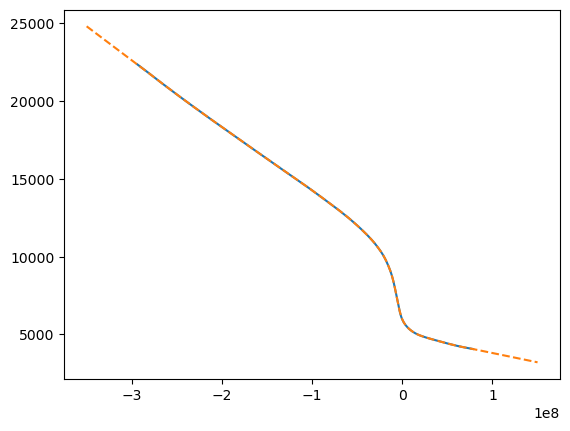

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2b7520c1bc10>

In [51]:
# An average 3D initial model
stagger_ini  = MUST.cut(MUST.SimpleInitialModel(stagger, Teff=5777.0, logg=4.5), z=(-3e8, 0.8e8))
stagger_ini2 = MUST.regrid(stagger_ini, collect(range(-3.5e8, 1.5e8, length=200)))
#MUST.for_dispatch(stagger_ini2, "solar_stagger_ext")

@show MUST.box_dimensions(6000, exp10(stagger_ini2.logg))

plt.plot(stagger_ini.z, stagger_ini.T)
plt.plot(stagger_ini2.z, stagger_ini2.T, ls="--")

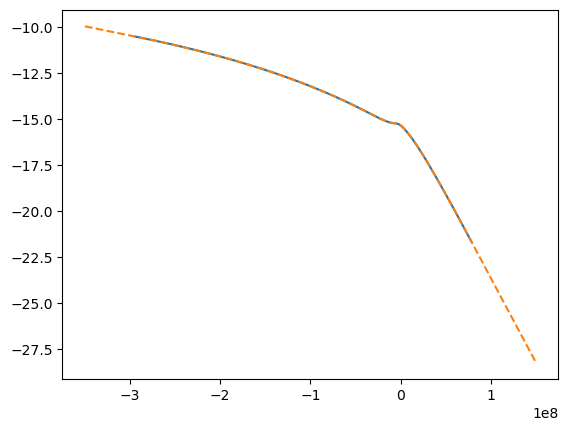

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2b74bd8c5400>

In [52]:
plt.plot(stagger_ini.z, stagger_ini.lnρ)
plt.plot(stagger_ini2.z, stagger_ini2.lnρ, ls="--")

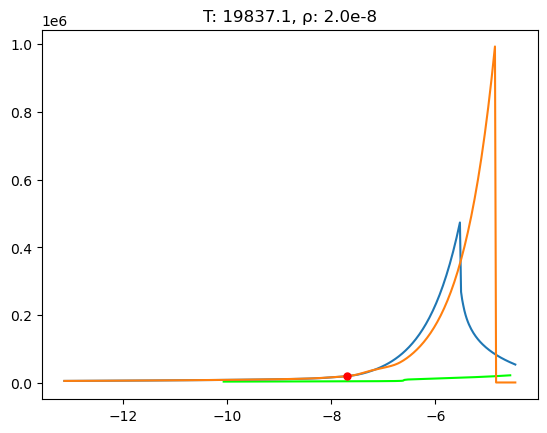

In [53]:
t_stagger = MUST.plane_statistic(MUST.mean, stagger, :T)
d_stagger = MUST.plane_statistic(MUST.mean, stagger, :d)
z_stagger = MUST.axis(stagger, :z)

d_stagger = log10.(d_stagger)

# Plotting
plt.title("T: $(t_ini), ρ: $(r_ini)", fontsize="large")

#plt.scatter(log10.(stagger[:d]), stagger[:T], s=0.05, color="k")
plt.plot(d_stagger, t_stagger, color="lime")

plt.plot(log10.(d_tso), t_tso, label="TS-EoS")
plt.plot(log10.(d_tab), t_tab, label="Tabgen-EoS")

plt.plot(log10(r_ini), t_ini, marker="o", markersize=5, color="red")

#plt.ylim(0,30000);

#plt.legend();

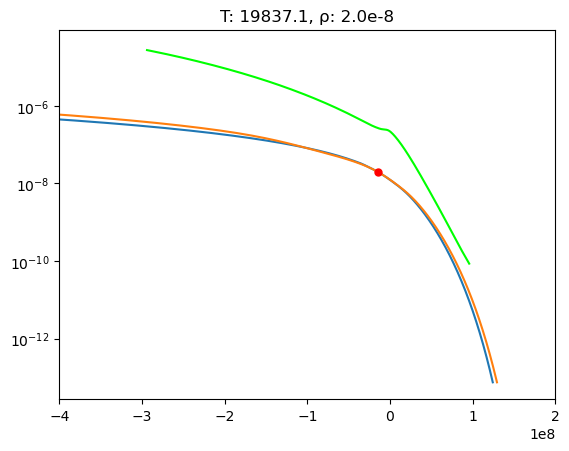

In [54]:
d_stagger = MUST.plane_statistic(MUST.mean, stagger, :d)
z_stagger = MUST.axis(stagger, :z)

# Plotting
plt.title("T: $(t_ini), ρ: $(r_ini)", fontsize="large")

#plt.scatter(stagger[:z], stagger[:T], s=0.05, color="k")
plt.plot(z_stagger, d_stagger, color="lime")

plt.plot(z_tso.*1e8, d_tso, label="TS-EoS")
plt.plot(z_tab.*1e8, d_tab, label="TS-EoS")

plt.plot(z0.*1e8, r_ini, marker="o", markersize=5, color="red")

plt.xlim(-4e8, 2e8)
plt.yscale("log")
#plt.legend();

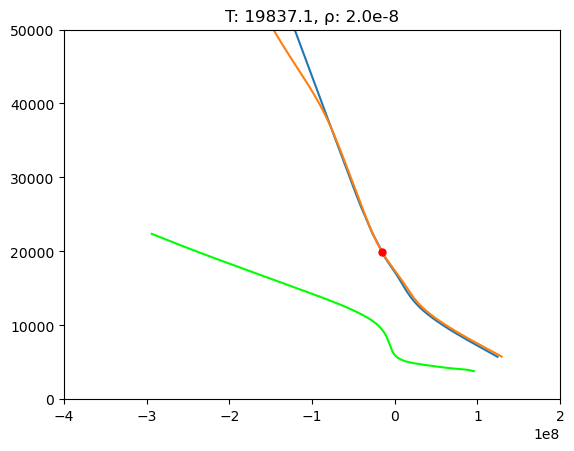

In [55]:
t_stagger = MUST.plane_statistic(MUST.mean, stagger, :T)
z_stagger = MUST.axis(stagger, :z)


# Plotting
plt.title("T: $(t_ini), ρ: $(r_ini)", fontsize="large")

#plt.scatter(stagger[:z], stagger[:T], s=0.05, color="k")
plt.plot(z_stagger, t_stagger, color="lime")

plt.plot(z_tso.*1e8, t_tso, label="TS-EoS")
plt.plot(z_tab.*1e8, t_tab, label="TS-EoS")

plt.plot(z0.*1e8, t_ini, marker="o", markersize=5, color="red")

plt.ylim(0,50000);
plt.xlim(-4e8, 2e8)

#plt.legend();

plot multiple initial conditions

In [56]:
t_ini = 1e4
r_ini = 3e-7
g_ini = 2.75e4;
z0    = 0.0


t_stagger = MUST.plane_statistic(MUST.mean, stagger, :T)
d_stagger = MUST.plane_statistic(MUST.mean, stagger, :d)
z_stagger = MUST.axis(stagger, :z)

z_tab,d_tab,ee_tab,t_tab,p_tab = init_adiabat(TAB, t_ini, r_ini, g_ini, ee_min=4.0, nz=400, i0=150, placement=z0);

z = []
d = []
t = []
e = []
p = []


z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini+700, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini+500, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini+200, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini,     r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini-200, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini-500, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])

z_tso,d_tso,ee_tso,t_tso,p_tso = init_adiabat(TSO, t_ini-700, r_ini, g_ini, ee_min=3.3, nz=400, i0=150, placement=z0)
append!(z, [z_tso]);append!(d, [d_tso]);append!(e, [ee_tso]);append!(t, [t_tso]);append!(p, [p_tso])
;

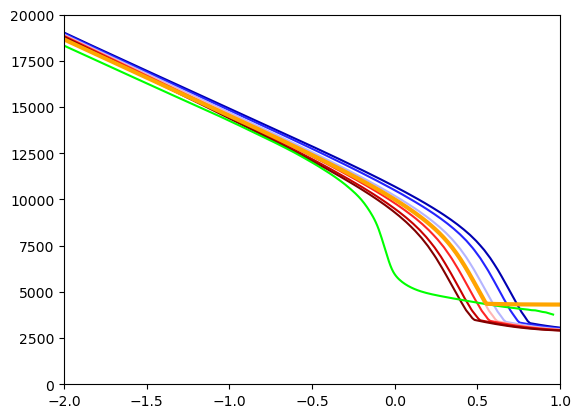

(0.0, 20000.0)

In [57]:
cmap  = plt.get_cmap("seismic")    # 11 discrete colors

for i in eachindex(z)
    plt.plot(z[i], t[i], color=cmap(i/length(z)))
end

plt.plot(z_stagger ./1e8, t_stagger, color="lime")
plt.plot(z_tab, t_tab, color="orange", lw=3)

plt.xlim(-2,1)
plt.ylim(0,20000)
#plt.yscale("log")

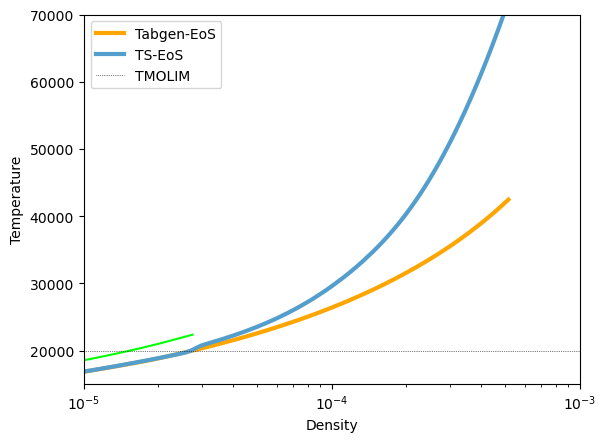

PyObject <matplotlib.legend.Legend object at 0x2b7520b9edf0>

In [58]:
cmap  = plt.get_cmap("Blues")    # 11 discrete colors

plt.plot(d_stagger, t_stagger, color="lime")
plt.plot(d_tab, t_tab, color="orange", lw=3, label="Tabgen-EoS")

for i in eachindex(z)
    i != 4 && continue
    plt.plot(d[i], t[i], color=cmap(i/length(z)), lw=3, label="TS-EoS")
end

plt.xscale("log")
plt.xlim(1e-5, 1e-3)
plt.ylim(15000,70000)
plt.axhline(20000, color="k", ls=":", lw=0.5, label="TMOLIM")

plt.xlabel("Density")
plt.ylabel("Temperature")

plt.legend()
#plt.yscale("log")

Compare the EoS themselves

In [59]:
@show minimum(TAB.lnRho_axis) maximum(TAB.lnRho_axis) 

minimum(TAB.lnRho_axis) = -36.841362f0
maximum(TAB.lnRho_axis) = -6.9077554f0


-6.9077554f0

In [60]:
@show minimum(TSO.lnRho_axis) maximum(TSO.lnRho_axis) 

minimum(TSO.lnRho_axis) = -34.538776f0
maximum(TSO.lnRho_axis) = -6.9077554f0


-6.9077554f0

In [61]:
#@show TAB.lnRho_axis[1650]
@show TAB.lnRho_axis[1650]
@show TSO.lnRho_axis[150]

TAB.lnRho_axis[1650] = -12.727773f0
TSO.lnRho_axis[150] = -12.870239f0


-12.870239f0

In [62]:
tab_ee_range = [Float32(TAB.params["EiMin"]), Float32(TAB.params["EiMax"])] 
tso_ee_range = [Float32(TSO.params["EiMin"]), Float32(TSO.params["EiMax"])] 
@show tab_e = MUST.bisect(TAB; ee=tab_ee_range, d=3e-7, T=10000)
@show tso_e = MUST.bisect(TSO; ee=tso_ee_range, d=3e-7, T=10000)
diff_e = tso_e - tab_e

tab_e = MUST.bisect(TAB; ee = tab_ee_range, d = 3.0e-7, T = 10000) = 5.112688f12
tso_e = MUST.bisect(TSO; ee = tso_ee_range, d = 3.0e-7, T = 10000) = 4.546265f12


-5.664229f11

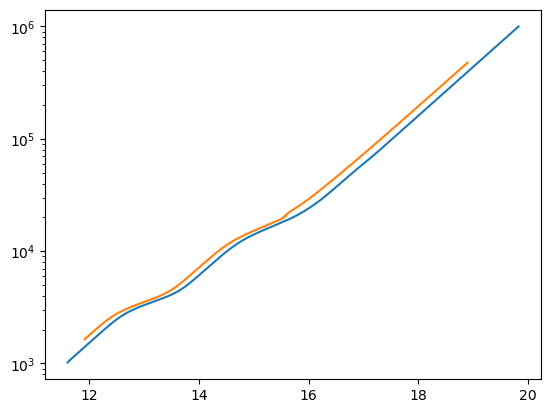

In [63]:
plt.plot(TAB.eostable[:, 1650, 1], TAB.eostable[:, 1650, 2], label="tabgen")
#plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 2], label="ts")
plt.plot(TSO.eostable[:, 150, 1], TSO.eostable[:, 150, 2], label="ts")

plt.yscale("log")

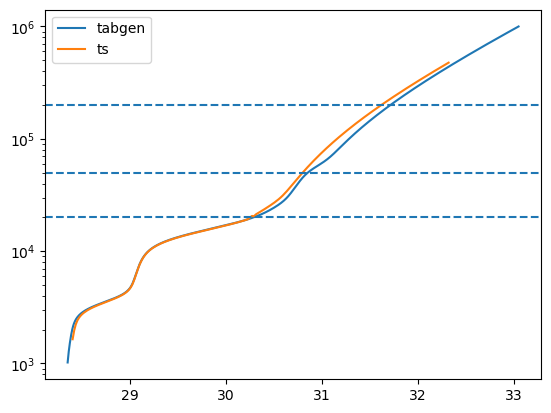

PyObject <matplotlib.legend.Legend object at 0x2b7520a18f10>

In [64]:
plt.plot(TAB.lnEi_axis, TAB.eostable[:, 1650, 2], label="tabgen")
plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 2], label="ts")
#plt.plot(TSO.lnEi_axis, TSO.eostable[:, 150, 2], label="ts")


plt.yscale("log")

#plt.axhline(300000)
plt.axhline(200000, ls="--")
plt.axhline(20000, ls="--")
plt.axhline(50000, ls="--")


#plt.ylim(1e4, 1e5)
#plt.xlim(29,31.5)

plt.legend()

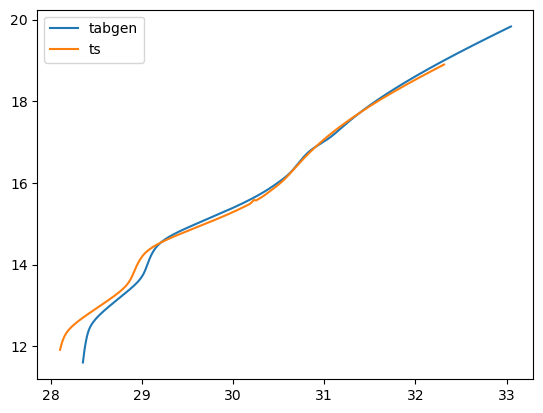

PyObject <matplotlib.legend.Legend object at 0x2b746bef7c10>

In [65]:
plt.plot(TAB.lnEi_axis, TAB.eostable[:, 1650, 1], label="tabgen")
#plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 1], label="ts")
plt.plot(TSO.lnEi_axis, TSO.eostable[:, 150, 1], label="ts")

plt.legend()

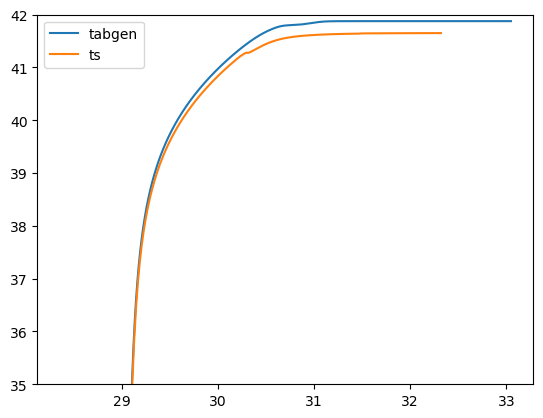

(35.0, 42.0)

In [66]:
plt.plot(TAB.lnEi_axis, TAB.eostable[:, 1650, 3], label="tabgen")
plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 3], label="ts")
#plt.plot(TSO.lnEi_axis, TSO.eostable[:, 150, 3], label="ts")


plt.legend()
plt.ylim(35,42)

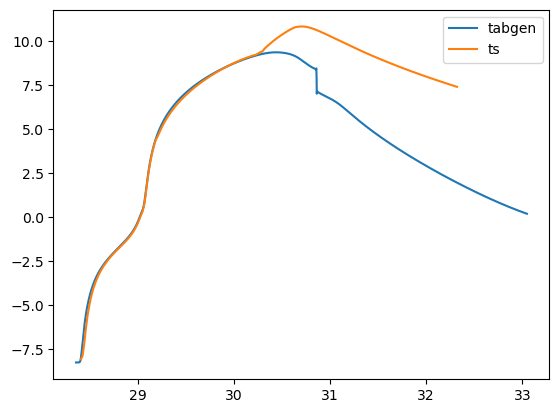

PyObject <matplotlib.legend.Legend object at 0x2b746bf7aa90>

In [67]:
plt.plot(TAB.lnEi_axis, TAB.eostable[:, 1650, 4], label="tabgen")
plt.plot(log.(exp.(TSO.lnEi_axis) .- diff_e), TSO.eostable[:, 150, 4], label="ts")
#plt.plot(TSO.lnEi_axis, TSO.eostable[:, 150, 4], label="ts")


plt.legend()